In [16]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Load Datasets
airports = pd.read_csv('data/airports.dat', header=None, index_col='Airport ID' ,names=['Airport ID','Airport Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude' , 'Altitude', 'Timezone', 'DST', 'Tz database timezone', 'Type', 'Source'])

routes = pd.read_csv('data/routes.dat', header=None, names=['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID', 'Destination Airport', 'Destination Airport ID', 'Codeshare', 'Stops', 'Equipment'])

In [3]:
airports.head()

,Airport Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
Airport ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
routes.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Destination Airport,Destination Airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
def plot_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=50, font_size=6, edge_color='gray')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


In [6]:
def create_flight_graph(airports, routes):
    G = nx.DiGraph()

    for _, airport in airports.iterrows():
        G.add_node(airport['Country'], name = airport['Airport Name'], city = airport['City'])
    
    for _, route in routes.iterrows():
        source_airport = route['Source Airport ID']
        destination_airport = route['Destination Airport ID']

        # Ignore routes that reference airports not registered on the dataset
        if source_airport == '\\N' or destination_airport == '\\N':
            continue
        if int(source_airport) not in airports.index or int(destination_airport) not in airports.index:
            continue

        # Excludes internal flights
        source_country = airports.loc[int(source_airport)]['Country']
        destination_country = airports.loc[int(destination_airport)]['Country']
        if source_country == destination_country:
            continue

        if G.has_edge(source_country, destination_country):
            G[source_country][destination_country]['weight'] += 1
        else:
            G.add_edge(source_country, destination_country, weight=1)
            

    return G

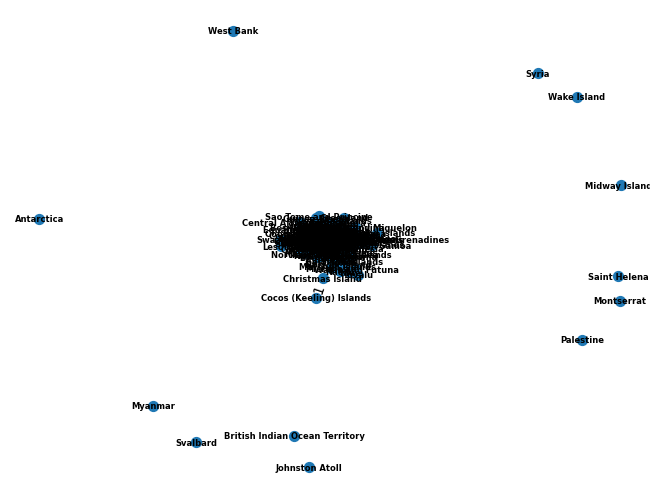

In [7]:
flight_graph = create_flight_graph(airports, routes)
plot_graph(flight_graph)

In [8]:
def get_maximum_degree(graph):
    degrees = dict(graph.degree())
    max_degree = max(degrees.values())
    nodes_with_max_degree = [node for node, degree in degrees.items() if degree == max_degree]
    return max_degree, nodes_with_max_degree

def find_nodes_with_degree_zero(graph, degree_type='in'):
    if degree_type == 'in':
        nodes_with_degree_zero = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    elif degree_type == 'out':
        nodes_with_degree_zero = [node for node in graph.nodes() if graph.out_degree(node) == 0]
    else:
        raise ValueError("Invalid degree_type. Use 'in' or 'out'.")

    return nodes_with_degree_zero

def get_nodes_with_highest_degrees(graph):
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())

    max_in_degree_node = max(in_degrees, key=in_degrees.get)
    max_out_degree_node = max(out_degrees, key=out_degrees.get)

    max_in_degree_value = in_degrees[max_in_degree_node]
    max_out_degree_value = out_degrees[max_out_degree_node]

    return [max_in_degree_node, max_in_degree_value], [max_out_degree_node, max_out_degree_value]

def find_heaviest_edge(graph):
    heaviest_edge = max(graph.edges(data=True), key=lambda x: x[2]['weight'])
    return heaviest_edge


def calculate_edge_weight(graph, source, target):
    if graph.has_edge(source, target):
        return graph[source][target]['weight']
    else:
        return None  # Edge does not exist
    
def get_heaviest_edges(graph, n=10):
    edges_with_weights = [(source, target, graph[source][target]['weight']) for source, target in graph.edges()]

    # Sort edges based on weight in descending order
    sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

    # Return the top n heaviest edges
    return sorted_edges[:n]

# Calculate and print interesting graph metrics

In [9]:
print(f"Number of nodes: {flight_graph.number_of_nodes()}")
print(f"Number of edges: {flight_graph.number_of_edges()}")

Number of nodes: 237
Number of edges: 4558


In [10]:
print("\nAdjacency Matrix:")
print(nx.adjacency_matrix(flight_graph).todense())


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
in0 = find_nodes_with_degree_zero(flight_graph, degree_type='in')
out0 = find_nodes_with_degree_zero(flight_graph, degree_type='out')

print("Nodes with IN dregee 0:")
print(len(in0))
print(in0)
print("Nodes with OUT dregee 0:")
print(len(out0))
print(out0)

Nodes with IN dregee 0:
13
['Saint Helena', 'British Indian Ocean Territory', 'Antarctica', 'West Bank', 'Syria', 'Midway Islands', 'Palestine', 'Montserrat', 'Johnston Atoll', 'Niue', 'Myanmar', 'Svalbard', 'Wake Island']
Nodes with OUT dregee 0:
12
['Saint Helena', 'British Indian Ocean Territory', 'Antarctica', 'West Bank', 'Syria', 'Midway Islands', 'Palestine', 'Montserrat', 'Johnston Atoll', 'Myanmar', 'Svalbard', 'Wake Island']


In [12]:
max_degree = get_maximum_degree(flight_graph)
print(f"The maximum degree in the graph is: {max_degree}")

maximums_degrees = get_nodes_with_highest_degrees(flight_graph)
print(f"The maximum in degree in the graph is: {maximums_degrees[0]}")
print(f"The maximum out degree in the graph is: {maximums_degrees[1]}")

print(f"Average in-degree: {sum(dict(flight_graph.in_degree()).values()) / flight_graph.number_of_nodes()}")
print(f"Average out-degree: {sum(dict(flight_graph.out_degree()).values()) / flight_graph.number_of_nodes()}")

The maximum degree in the graph is: (227, ['France'])
The maximum in degree in the graph is: ['France', 112]
The maximum out degree in the graph is: ['France', 115]
Average in-degree: 19.23206751054852
Average out-degree: 19.23206751054852


Text(0.5, 1.0, 'Heaviest edges n= 20')

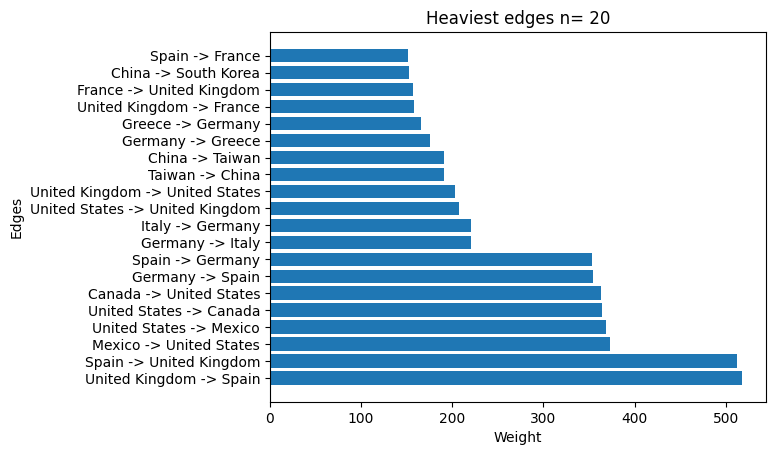

In [15]:
top_edges = get_heaviest_edges(flight_graph, 20)

edges = [f"{edge[0]} -> {edge[1]}" for edge in top_edges]
weights = [edge[2] for edge in top_edges]

plt.barh(edges, weights)
plt.xlabel("Weight")
plt.ylabel("Edges")
plt.title(f"Heaviest edges n= {len(top_edges)}")

In [14]:
    weak_connected_components = nx.number_weakly_connected_components(flight_graph)
    print(f"Weak connected components: {weak_connected_components}")

    strong_connected_components = nx.number_strongly_connected_components(flight_graph)
    print(f"Strong connected components: {strong_connected_components}")

Weak connected components: 13
Strong connected components: 14


In [100]:
# TESTAR REMOVER AEORPORTOES OU 

nx.betweenness_centrality

/var/folders/rc/hwxyq4_13pvfp9js04v5z5300000gn/T/ipykernel_19379/1570669816.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


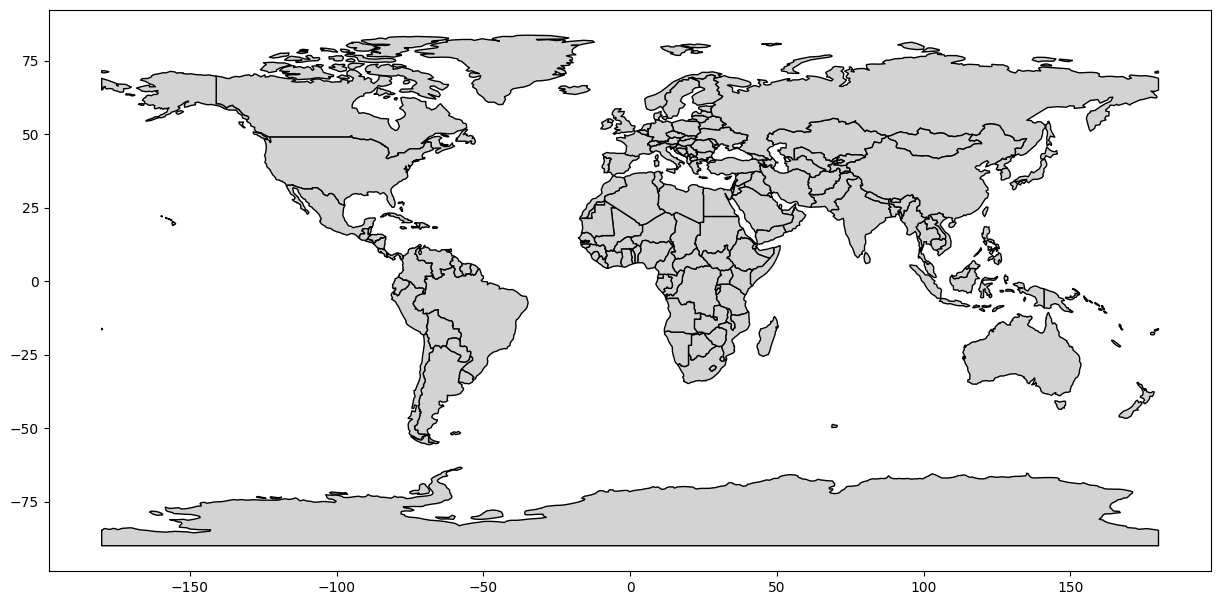

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Crie uma figura e eixos para o mapa
fig, ax = plt.subplots(figsize=(15, 10))

# Desenhe os países no mapa
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Mostre o mapa
plt.show()


/var/folders/rc/hwxyq4_13pvfp9js04v5z5300000gn/T/ipykernel_19379/1589579270.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for country, coords in world.geometry.centroid.iteritems():


AttributeError: 'GeoSeries' object has no attribute 'iteritems'